# Synthetic worm image generator

This notebook should result in the creation of a set of realistic but synthetic images (and ground-truth masks) of c. elegans worms.

### Imports

In [1]:
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
from copy import copy

## Pseudocode

load image

choose a mask

worm = pixels corresponding to this mask from originial image

apply transform to worm

apply transform to mask

insert transformed worm into original image

save image
save mask

# Functions


In [2]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 4)).astype(np.uint8)[:,:,:3]

In [3]:
def synthesise_worms(image_np, masks, trans_scale=30, rot_scale=45):
    new_image = copy(image_np)

    for m in range(int(len(masks)/2)):

        shifts = [int(np.random.normal(scale=trans_scale)),int(np.random.normal(scale=trans_scale)),0]
        angle = np.random.normal(rot_scale)

        worm_mask = masks[m]
        worm_where = np.where(worm_mask)

        #Hack to catch cases where the provided mask is empty
        if not worm_where[0].size:
            continue

        worm_center = tuple((int(np.mean(worm_where[1])), int(np.mean(worm_where[0]))))
        rot_mat = cv2.getRotationMatrix2D(worm_center, angle, 1.0)
        rotated_image = cv2.warpAffine(src=image_np, M=rot_mat, dsize=image_np.shape[:2], flags=cv2.INTER_LINEAR)
        rotated_mask = cv2.warpAffine(worm_mask, rot_mat, worm_mask.shape[:2], flags=cv2.INTER_LINEAR)
        rotated_where = np.where(rotated_mask)

        # new_image[rotated_where] = rotated_image[rotated_where]


        # worm_where_shifted = np.where(worm_mask)
        worm_where_shifted = np.where(rotated_mask)

        for i,j in zip(worm_where_shifted,shifts):
            if np.max(i+j) >= image_np.shape[0] or np.min(i+j) < 0:
                pass
            else:
                i += j

        new_image[worm_where_shifted] = rotated_image[rotated_where]
        new_mask = np.zeros(masks[m].shape,dtype=np.uint8)
        new_mask[worm_where_shifted] = 255
        masks.append(new_mask)
    
    return new_image, masks


In [4]:
def plot_old_and_new(image_np, new_image, plot_masks=False, masks=None):
    w = 2
    if plot_masks:
        w = 3
    
    plt.figure(figsize=IMAGE_SIZE)

    plt.subplot(1,w,1)
    plt.imshow(image_np)

    plt.subplot(1,w,2)
    plt.imshow(new_image)

    if plot_masks:
        masks_array = np.asarray(masks)
        mask_sum = np.sum(masks_array, axis=3)
        mask_sum = np.sum(mask_sum, axis=0)
        plt.subplot(1,w,3)
        plt.imshow(mask_sum)
        
    plt.show()
    plt.close()

In [5]:
def plot_synthetic_images(img_list, plot_masks=False, masks=None, names=None):
    N = len(img_list)
    if plot_masks:
        N+=1
    
    plt.figure(figsize=IMAGE_SIZE)
    
    for n in range(len(img_list)):
        plt.subplot(1,N,n+1)
        if names:
            plt.gca().set_title(names[n])
        plt.imshow(img_list[n])
        
    if plot_masks:
        masks_array = np.asarray(masks)
        mask_sum = np.sum(masks_array, axis=3)
        mask_sum = np.sum(mask_sum, axis=0)
        plt.subplot(1,N,N)
        if names:
            plt.gca().set_title('All masks')
        plt.imshow(mask_sum)
    
    plt.show()
    plt.close()

In [6]:
def save_synth_data(syn_image, syn_masks, fname):
    OUTPUT_IMAGE_DIR = os.path.join(PATH_TO_OUTPUTS_DIR, '{}/image'.format(fname))
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
    
    OUTPUT_IMAGE_PATH = os.path.join(OUTPUT_IMAGE_DIR, 'image_{}.png'.format(fname))
    
    output_image = Image.fromarray(syn_image)
    output_image.save(OUTPUT_IMAGE_PATH)
    
    
    OUTPUT_MASKS_DIR = os.path.join(PATH_TO_OUTPUTS_DIR, '{}/masks'.format(fname))
    os.makedirs(OUTPUT_MASKS_DIR, exist_ok=True)
    
    for m in range(len(syn_masks)):
        OUTPUT_MASK_PATH = os.path.join(OUTPUT_MASKS_DIR, 'mask_{}.png'.format(m))
        output_mask = Image.fromarray(syn_masks[m])
        output_mask.save(OUTPUT_MASK_PATH)

# Main body


## Define data, paths, etc

In [7]:
NUM_IMAGES = 5

# Size, in inches, of the output images.
IMAGE_SIZE = (50,50)


PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data_pre_exams/full_images/'

PATH_TO_OUTPUTS_DIR = '/Users/daniel/Documents/UCL/Project/Data/synthesised_val_data/'

FNAMES = [f for f in os.listdir(PATH_TO_TEST_IMAGES_DIR) if not f.startswith('.')]
FNAMES = sorted(FNAMES, key=int)[:NUM_IMAGES]



## Perform data synthesis

In [8]:
for fname in FNAMES:
    print(fname)
    TEST_IMAGE_PATH = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(fname,fname))
    image = Image.open(TEST_IMAGE_PATH)
    image_np = load_image_into_numpy_array(image)

    MASKS_DIR = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/masks/'.format(fname))
    MASK_FNAMES = sorted([f for f in os.listdir(MASKS_DIR) if not f.startswith('.')])

    masks = []
    for m in MASK_FNAMES:
        mask = Image.open(os.path.join(MASKS_DIR,m))
        masks.append(np.asarray(mask)[:,:,:3])
    
#     syn_image, syn_masks = synthesise_worms(image_np, masks, trans_scale=20, rot_scale=30)
    
#     plot_old_and_new(image_np, syn_image, plot_masks=False, masks=masks)
    
#     save_synth_data(syn_image, syn_masks, fname)
        
    

0
1
2
3
4


# Poisson blending

In [9]:
# import cv2
# import numpy as np
 
# # Read images : src image will be cloned into dst
# im = cv2.imread("images/wood-texture.jpg")
# obj= cv2.imread("images/iloveyouticket.jpg")
 
# # Create an all white mask
# mask = 255 * np.ones(obj.shape, obj.dtype)
 
# # The location of the center of the src in the dst
# width, height, channels = im.shape
# center = (height/2, width/2)
 
# # Seamlessly clone src into dst and put the results in output
# normal_clone = cv2.seamlessClone(obj, im, mask, center, cv2.NORMAL_CLONE)
# mixed_clone = cv2.seamlessClone(obj, im, mask, center, cv2.MIXED_CLONE)
 
# # Write results
# cv2.imwrite("images/opencv-normal-clone-example.jpg", normal_clone)
# cv2.imwrite("images/opencv-mixed-clone-example.jpg", mixed_clone)

In [10]:
def seamless_synthesise_worms(image_np, masks, trans_scale=30, rot_scale=45):
    new_image = copy(image_np)
#     cv2_new_image = copy(image_np)

    for m in range(int(len(masks)/2)):

        shifts = [int(np.random.normal(scale=trans_scale)),int(np.random.normal(scale=trans_scale)),0]
        angle = np.random.normal(rot_scale)

        worm_mask = masks[m]
        worm_where = np.where(worm_mask)
        

        #Hack to catch cases where the provided mask is empty
        if not worm_where[0].size:
            continue

        worm_center = tuple((int(np.mean(worm_where[1])), int(np.mean(worm_where[0]))))
        rot_mat = cv2.getRotationMatrix2D(worm_center, angle, 1.0)
        rotated_image = cv2.warpAffine(src=image_np, M=rot_mat, dsize=image_np.shape[:2], flags=cv2.INTER_LINEAR)
        rotated_mask = cv2.warpAffine(worm_mask, rot_mat, worm_mask.shape[:2], flags=cv2.INTER_LINEAR)
        rotated_where = np.where(rotated_mask)

        # new_image[rotated_where] = rotated_image[rotated_where]


        # worm_where_shifted = np.where(worm_mask)
        worm_where_shifted = np.where(rotated_mask)

        for i,j in zip(worm_where_shifted,shifts):
            if np.max(i+j) >= image_np.shape[0] or np.min(i+j) < 0:
                pass
            else:
                i += j
        
        shifted_center = tuple((int(np.mean(worm_where_shifted[1])), int(np.mean(worm_where_shifted[0]))))
        
        
        x = np.min(worm_where_shifted[1])
        w = np.max(worm_where_shifted[1]) - x
        
        y = np.min(worm_where_shifted[0])
        h = np.max(worm_where_shifted[0]) - y
        
        cv2_mask = np.zeros(masks[m].shape,dtype=np.uint8)
        cv2_mask[y:y+h, x:x+w,:] = 255
        
        new_image[worm_where_shifted] = rotated_image[rotated_where]
        new_mask = np.zeros(masks[m].shape,dtype=np.uint8)
        new_mask[worm_where_shifted] = 255
        masks.append(new_mask)
        
        # Seamlessly clone src into dst and put the results in output
        normal_clone = cv2.seamlessClone(new_image, image_np, cv2_mask, shifted_center, cv2.NORMAL_CLONE)
        mixed_clone = cv2.seamlessClone(new_image, image_np, cv2_mask, shifted_center, cv2.MIXED_CLONE)
        
    return new_image, masks, mixed_clone



In [15]:
def seamless_synthesise_worms_2(image_np, masks, trans_scale=30, rot_scale=45):
    new_image = copy(image_np)
    cv2_blended_image = copy(image_np)
    cv2_normal_cloned_image = copy(image_np)

#     for m in range(int(len(masks)/2)):
    for m in range(int(len(masks))):

        shifts = [int(np.random.normal(scale=trans_scale)),int(np.random.normal(scale=trans_scale)),0]
        angle = np.random.normal(rot_scale)

        worm_mask = masks[m]
        worm_where = np.where(worm_mask)
        

        #Hack to catch cases where the provided mask is empty
        if not worm_where[0].size:
            continue

        worm_center = tuple((int(np.mean(worm_where[1])), int(np.mean(worm_where[0]))))
        rot_mat = cv2.getRotationMatrix2D(worm_center, angle, 1.0)
        rotated_image = cv2.warpAffine(src=image_np, M=rot_mat, dsize=image_np.shape[:2], flags=cv2.INTER_LINEAR)
        rotated_mask = cv2.warpAffine(worm_mask, rot_mat, worm_mask.shape[:2], flags=cv2.INTER_LINEAR)
        rotated_where = np.where(rotated_mask)

        # new_image[rotated_where] = rotated_image[rotated_where]


        # worm_where_shifted = np.where(worm_mask)
        worm_where_shifted = np.where(rotated_mask)

        for i,j in zip(worm_where_shifted,shifts):
            if np.max(i+j) >= image_np.shape[0] or np.min(i+j) < 0:
                pass
            else:
                i += j
        
        shifted_center = tuple((int(np.mean(worm_where_shifted[1])), int(np.mean(worm_where_shifted[0]))))
        
        
        x = np.min(worm_where_shifted[1])
        w = np.max(worm_where_shifted[1]) - x
        
        y = np.min(worm_where_shifted[0])
        h = np.max(worm_where_shifted[0]) - y
        
        cv2_mask = np.zeros(masks[m].shape,dtype=np.uint8)
        cv2_mask[y:y+h, x:x+w,:] = 255
        
        #just rotated
        x_rot = np.min(rotated_where[1])
        w_rot = np.max(rotated_where[1]) - x_rot
        
        y_rot = np.min(rotated_where[0])
        h_rot = np.max(rotated_where[0]) - y_rot
        
        cv2_mask_rot = np.zeros(masks[m].shape,dtype=np.uint8)
        cv2_mask_rot[y_rot:y_rot+h_rot, x_rot:x_rot+w_rot,:] = 255
        
        new_image[worm_where_shifted] = rotated_image[rotated_where]
        new_mask = np.zeros(masks[m].shape,dtype=np.uint8)
        new_mask[worm_where_shifted] = 255
        masks.append(new_mask)
        
#         cv2_normal_cloned_image = cv2.seamlessClone(rotated_image, cv2_normal_cloned_image, cv2_mask, shifted_center, cv2.NORMAL_CLONE)
        
        cv2_blended_image = cv2.seamlessClone(rotated_image, cv2_blended_image, cv2_mask_rot, shifted_center, cv2.MIXED_CLONE)
#         cv2_new_image = mixed_clone
        
    return new_image, masks, cv2_blended_image




0


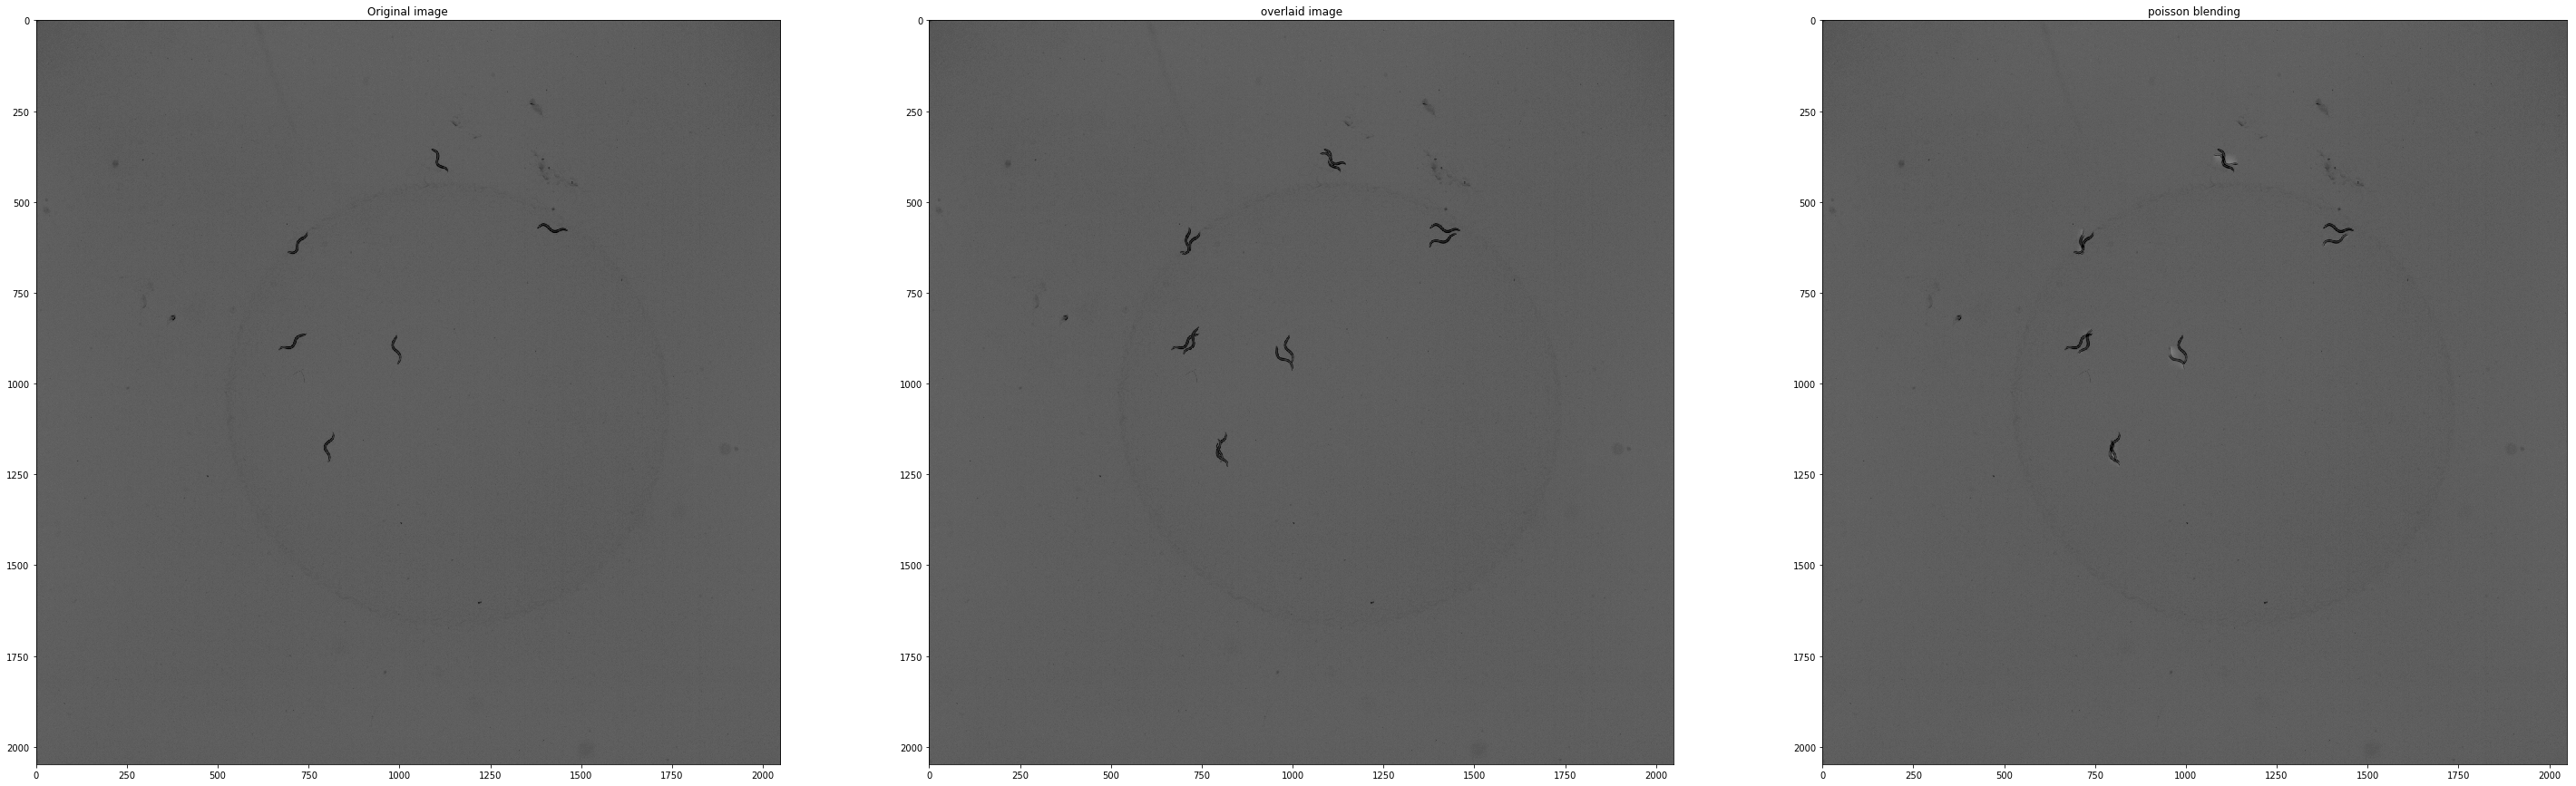

1


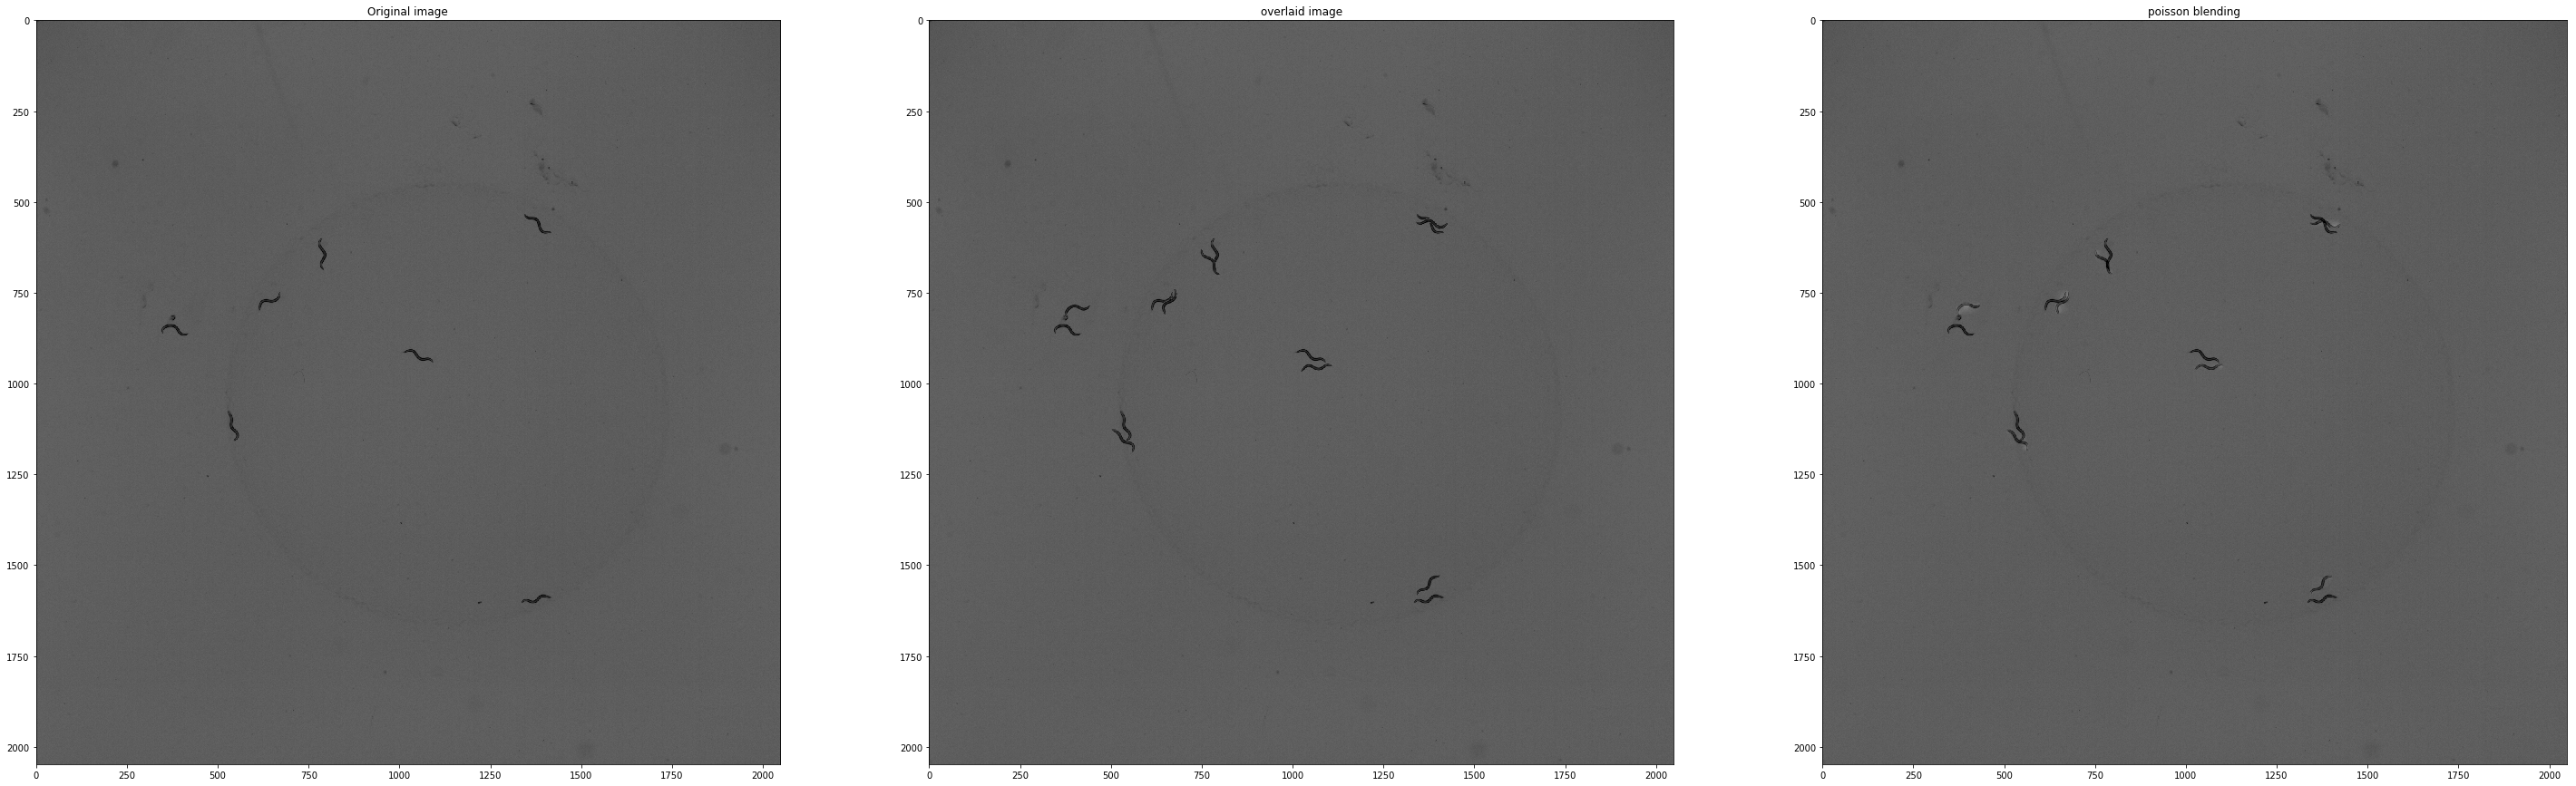

2


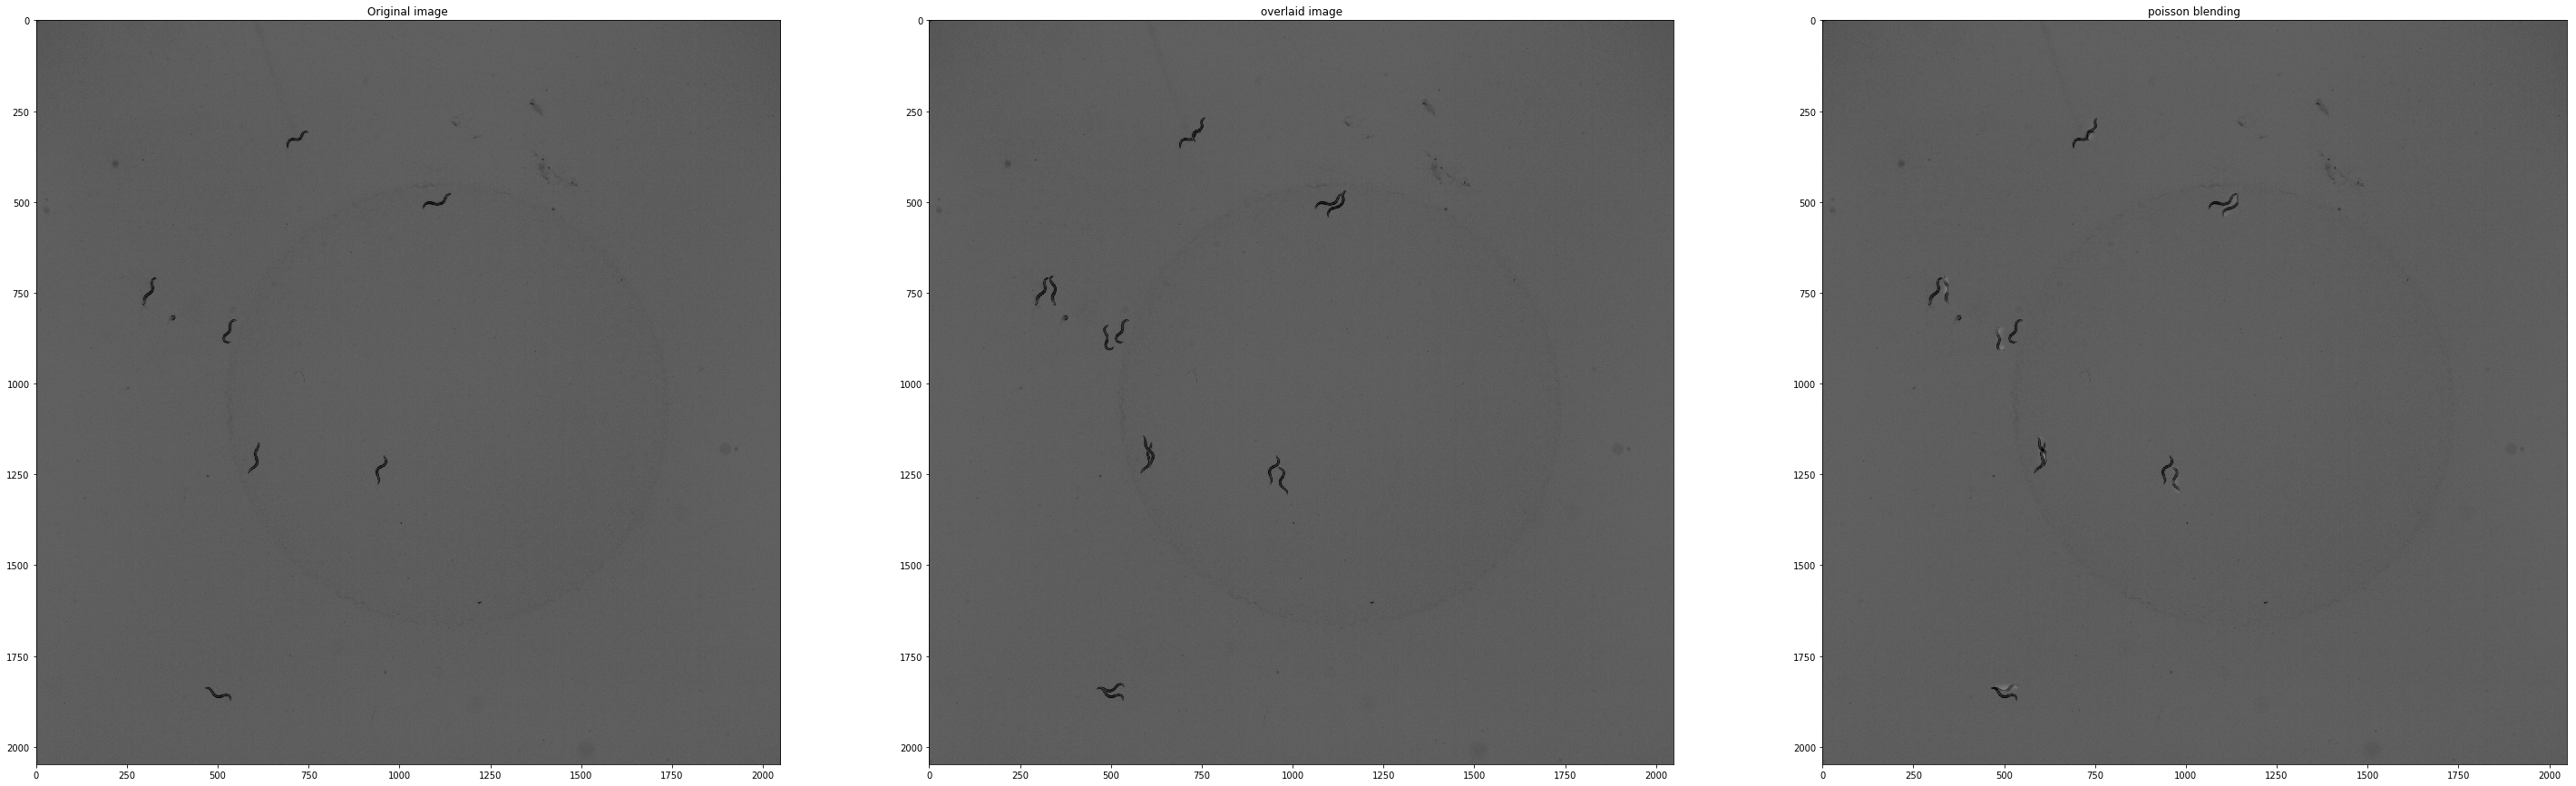

3


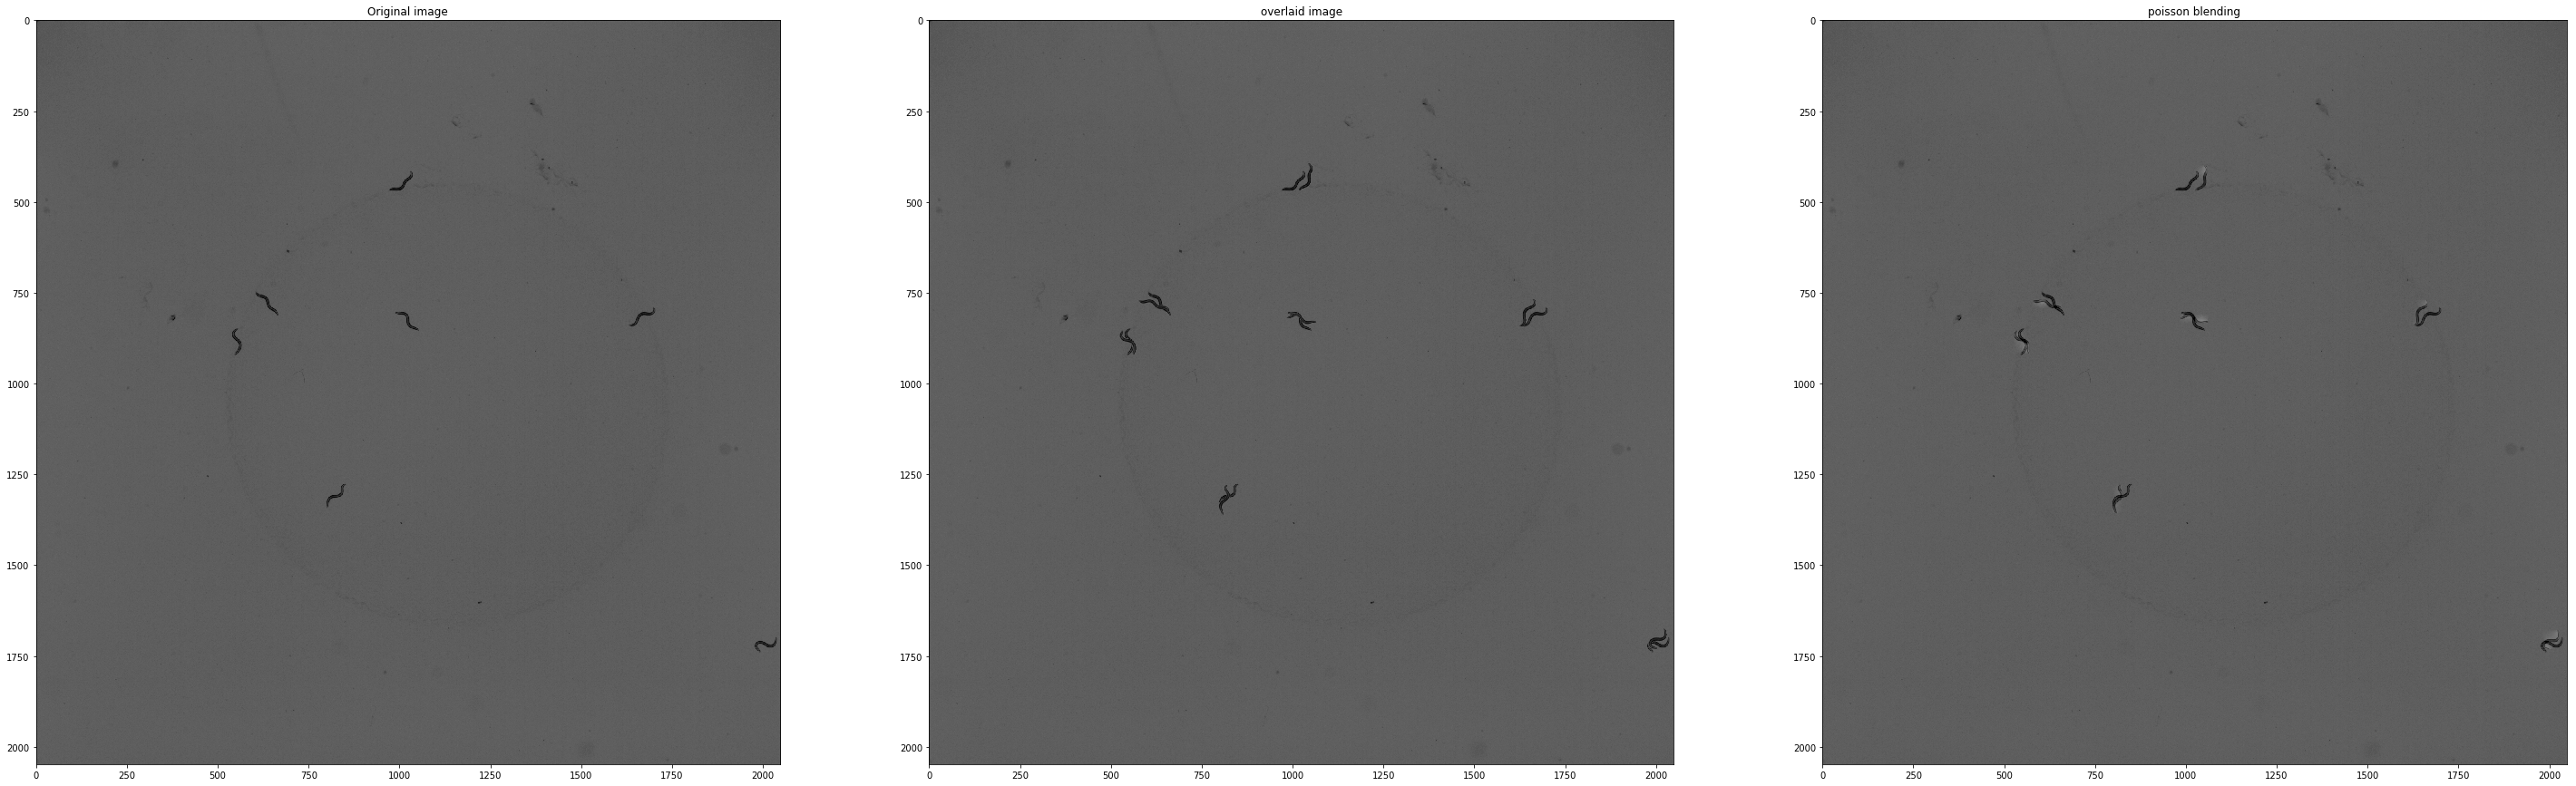

4


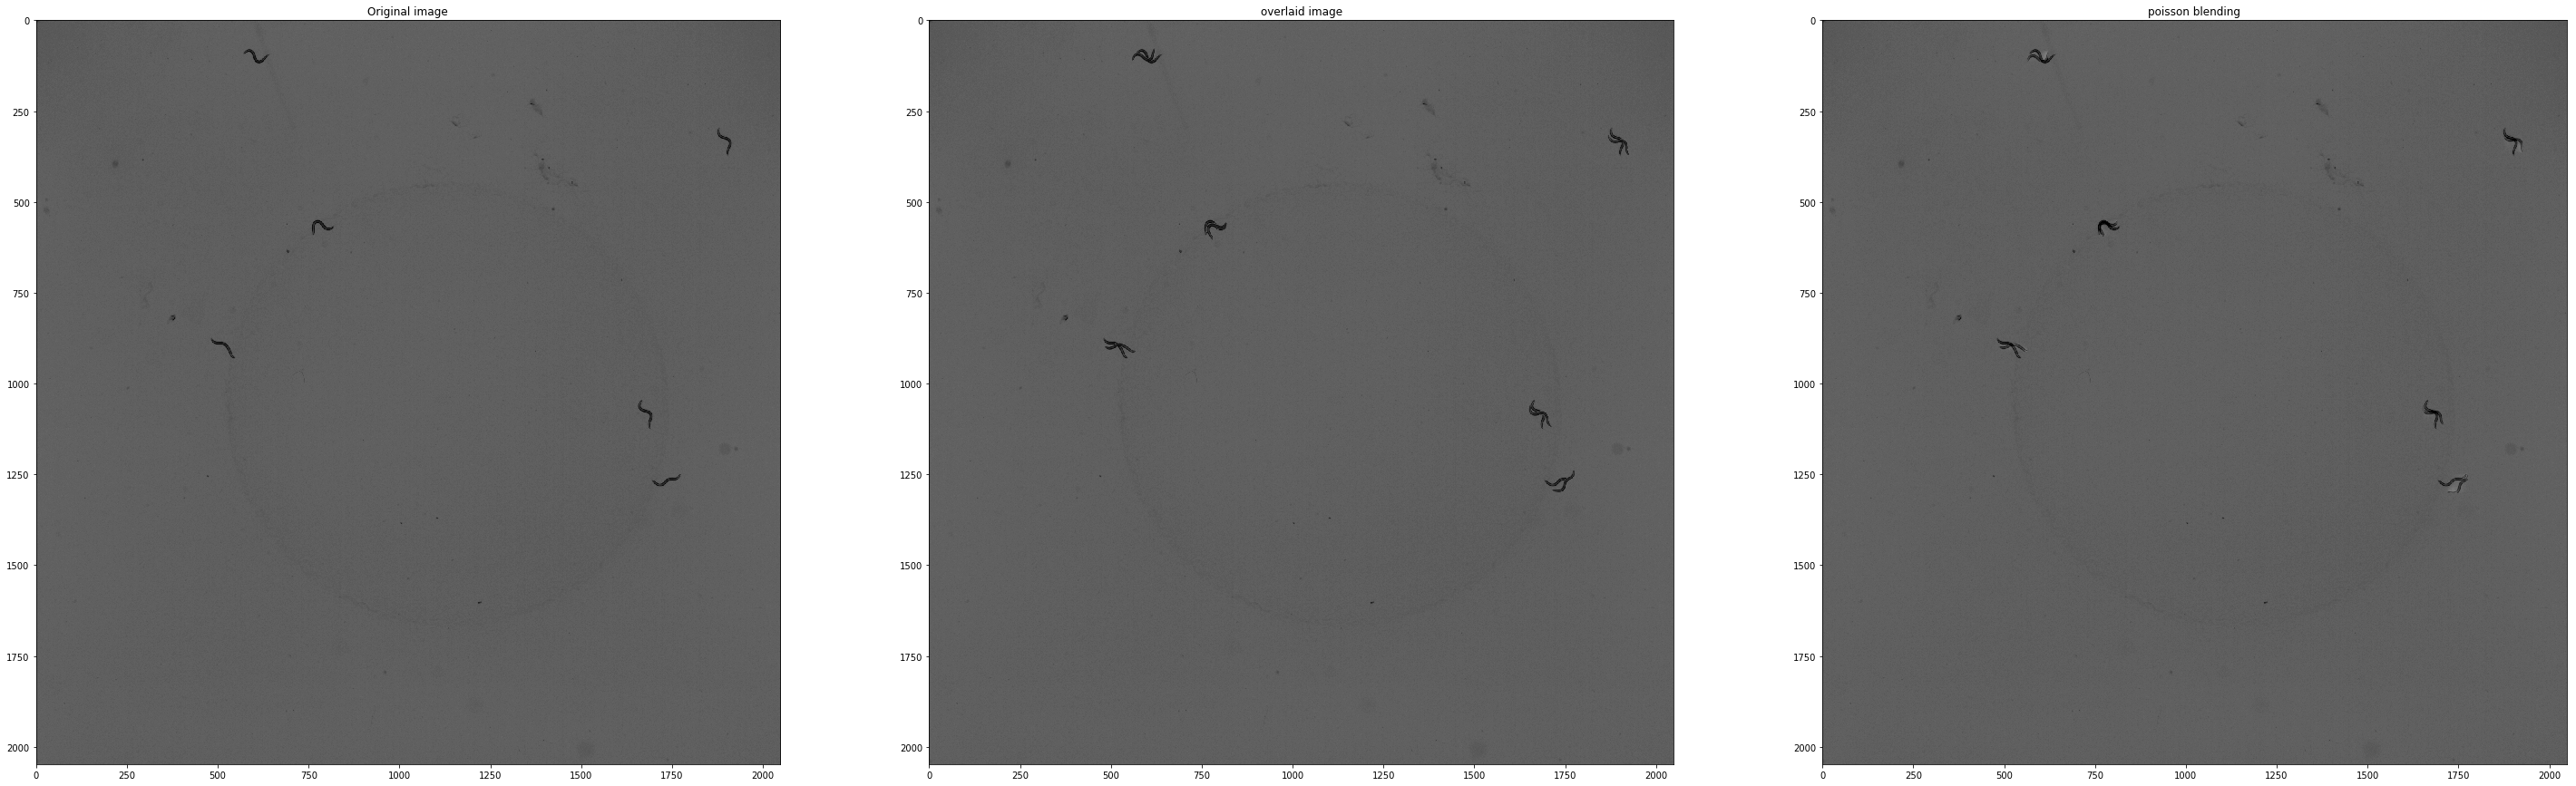

In [16]:
for fname in FNAMES:
    print(fname)
    TEST_IMAGE_PATH = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(fname,fname))
    image = Image.open(TEST_IMAGE_PATH)
    image_np = load_image_into_numpy_array(image)

    MASKS_DIR = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/masks/'.format(fname))
    MASK_FNAMES = sorted([f for f in os.listdir(MASKS_DIR) if not f.startswith('.')])

    masks = []
    for m in MASK_FNAMES:
        mask = Image.open(os.path.join(MASKS_DIR,m))
        masks.append(np.asarray(mask)[:,:,:3])
    
    syn_image, syn_masks, mixed_clone = seamless_synthesise_worms_2(image_np, masks, trans_scale=20, rot_scale=30)
    
#     plot_old_and_new(normal_clone, mixed_clone, plot_masks=False, masks=masks)
    
    names = ['Original image', 'overlaid image', 'poisson blending']
    plot_synthetic_images([image_np, syn_image, mixed_clone], names=names)
#     save_synth_data(syn_image, syn_masks, fname)

    